In [1]:
library(tidyverse)
library(magrittr)
library(ggplot2)
library(rscones2)

wd <- "/bioinfo/users/hcliment/easyGWASCore/data/testing/scones/skat/"

SKAT <- 0
CHISQ <- 1

CONSISTENCY <- 1
INFORMATION <- 2

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand



# Network structure

Parsed with column specification:
cols(
  X1 = col_integer(),
  X2 = col_integer(),
  X3 = col_integer(),
  X4 = col_integer()
)


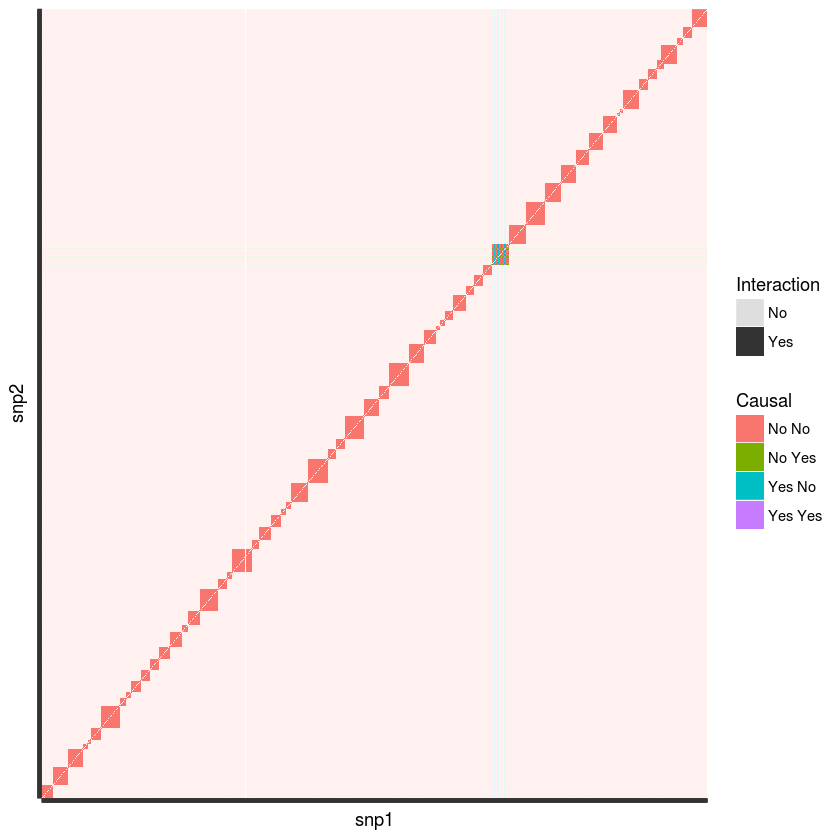

In [2]:
net <- read_delim(paste0(wd, "network.txt"), delim = " ", col_names = F)

scores <- net %>% 
  set_colnames(c("chr","pos","chr2","pos2")) %>%
  select(chr, pos) %>%
  unique %>%
  mutate(snp = paste0("rs", pos)) %>%
  mutate(causal = ifelse(pos %in% ( 1 + c(676, 679, 680, 682, 684, 685, 686, 690, 695, 696)), "Yes", "No"))

net %>% select(X2,X4) %>% table  %>%
  apply(1, function(x) x > 0) %>% as.data.frame()  %>%
  set_colnames(., paste0("rs", colnames(.))) %>% mutate(., rs = colnames(.)) %>%
  gather(rs) %>%
  set_colnames(c("snp1", "snp2", "interaction")) %>%
  merge(scores %>% select(snp,chr,pos,causal), by.x="snp1", by.y="snp") %>%
  merge(scores %>% select(snp,chr,pos,causal), by.x="snp2", by.y="snp", suffixes = c("1", "2")) %>%
  arrange(chr1,pos1,chr2,pos2) %>%
  mutate(snp1 = factor(snp1, levels = scores %>% arrange(chr,pos) %>% .$snp),
        snp2 = factor(snp2, levels = scores %>% arrange(chr,pos) %>% .$snp),
        interaction = ifelse(interaction, "Yes", "No")) %>%
  ggplot(aes(x=snp1, y=snp2, fill=paste(causal1, causal2), alpha=interaction)) +
    geom_tile() +
    theme(axis.text.x=element_blank(), axis.text.y=element_blank()) + 
    labs(fill = "Causal", alpha = "Interaction")

Dominik's example portrays a case with a single causal gene, of which only a few variants are correlated with the disease. Also, this is not visible here, but every SNP has only two genotypes, instead of the three possible ones. This made necessary to implement a line in the chisq calculation to remove 0 rows from the matrix.

# Scoring function

In [2]:
# do a CONSISTENCY gridsearch for skat and chisq
## 40 x 40 grid
skat40 <- test_associations_gridsearch(SKAT, wd, 40, 1, CONSISTENCY)
chisq40 <- test_associations_gridsearch(CHISQ, wd, 40, 1, CONSISTENCY)

In [3]:
## 10 x 10 grid
skat10 <- test_associations_gridsearch(SKAT, wd, 10, 1, CONSISTENCY)
chisq10 <- test_associations_gridsearch(CHISQ, wd, 10, 1, CONSISTENCY)


Call:
lm(formula = skat ~ chisq, data = .)

Residuals:
   Min     1Q Median     3Q    Max 
-14454   -681    291    824  40553 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -479.41      93.44  -5.131 3.47e-07 ***
chisq        1276.34      13.52  94.433  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2745 on 998 degrees of freedom
Multiple R-squared:  0.8994,	Adjusted R-squared:  0.8992 
F-statistic:  8918 on 1 and 998 DF,  p-value: < 2.2e-16


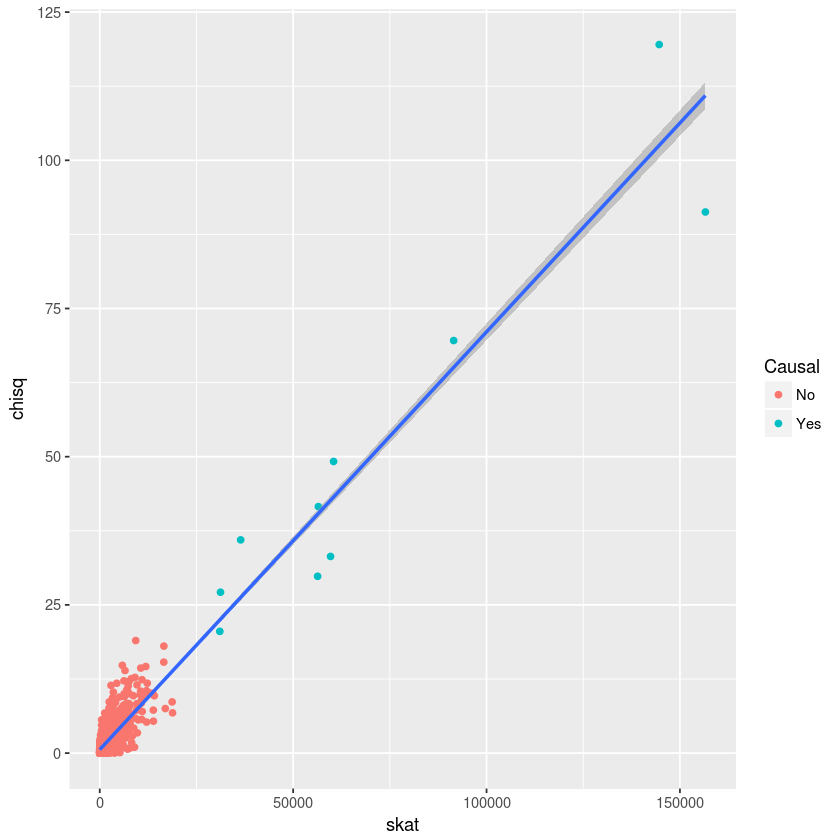

In [6]:
data.frame(skat = skat10$scores, chisq = chisq10$scores, causal = skat10$indicator) %>%
    mutate(Causal = ifelse(causal == 1, "Yes", "No")) %>%
    ggplot(aes(x = skat, y = chisq)) +
        geom_point(aes(color = Causal)) + 
        geom_smooth(method = lm, alpha = 0.5)

# fit a linear model
data.frame(skat = skat10$scores, chisq = chisq10$scores) %>%
    lm( skat ~ chisq, data = .) %>%
    summary

SKAT and chisq have a pretty good correlation.

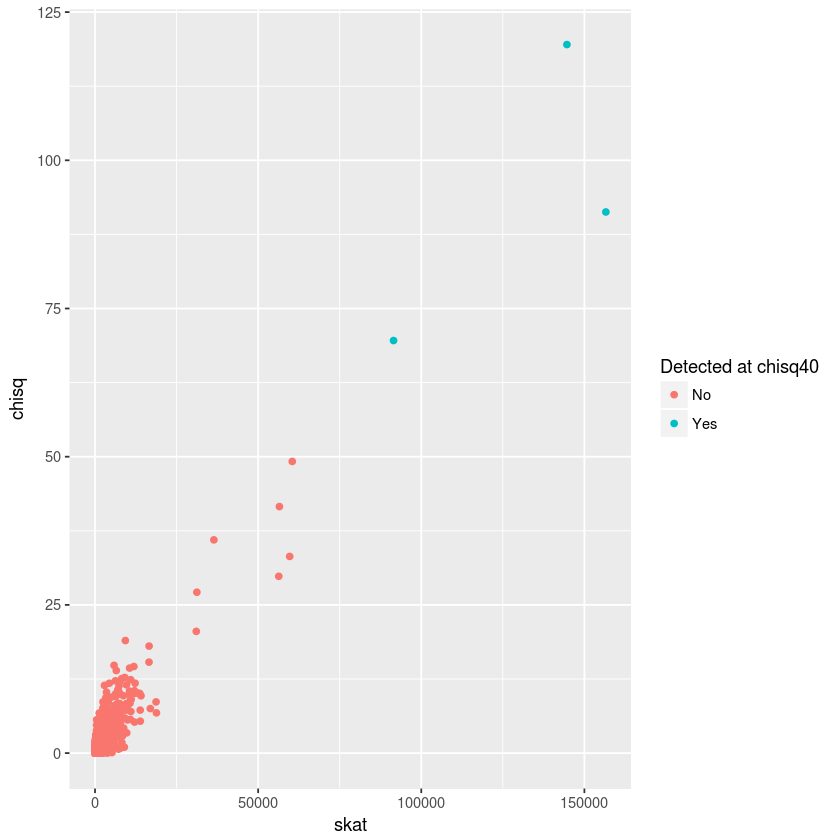

In [10]:
data.frame(skat = skat10$scores, chisq = chisq10$scores, causal = chisq40$indicator) %>%
    mutate(Detected = ifelse(causal == 1, "Yes", "No")) %>%
    ggplot(aes(x = skat, y = chisq)) +
        geom_point(aes(color = Detected)) + 
        labs(color = "Detected at chisq40")

However, chisq is underperforming at the detection. Let's try without enforcing the consistency across folds.

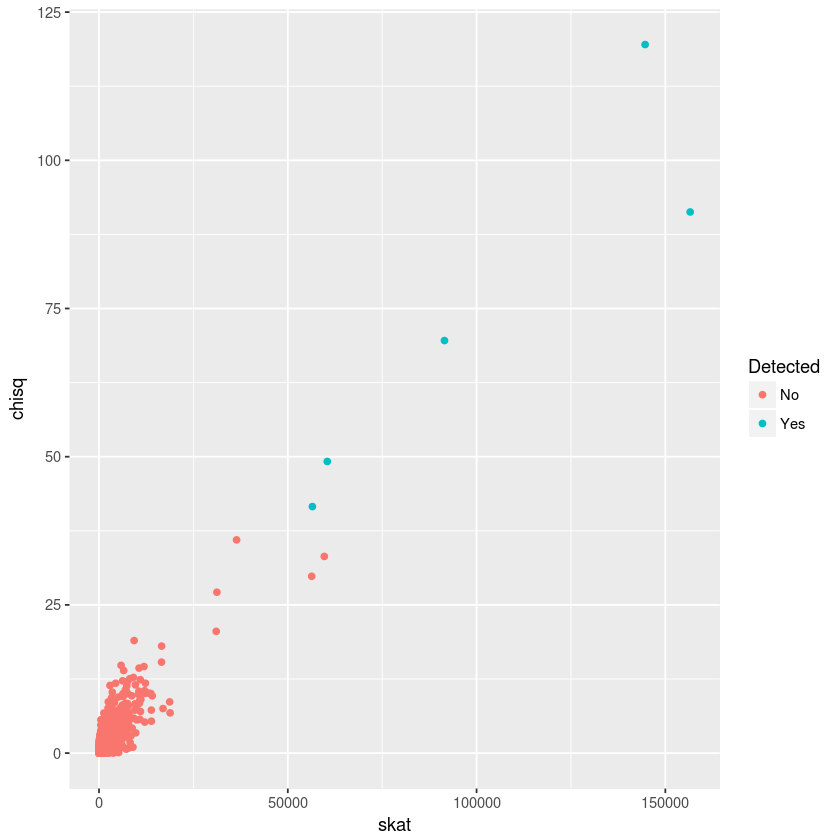

In [11]:
chisq <- test_associations(CHISQ, wd, chisq40$lambda, chisq40$eta)
data.frame(skat = skat10$scores, chisq = chisq$scores, causal = chisq$indicator) %>%
    mutate(Detected = ifelse(causal == 1, "Yes", "No")) %>%
    ggplot(aes(x = skat, y = chisq)) +
        geom_point(aes(color = Detected))

Still only half of the SNPs are selected. Let's try to scale the lambda and eta from the skat test to see how they perform.

    chisq
skat   0   1
   0 986   4
   1   0  10

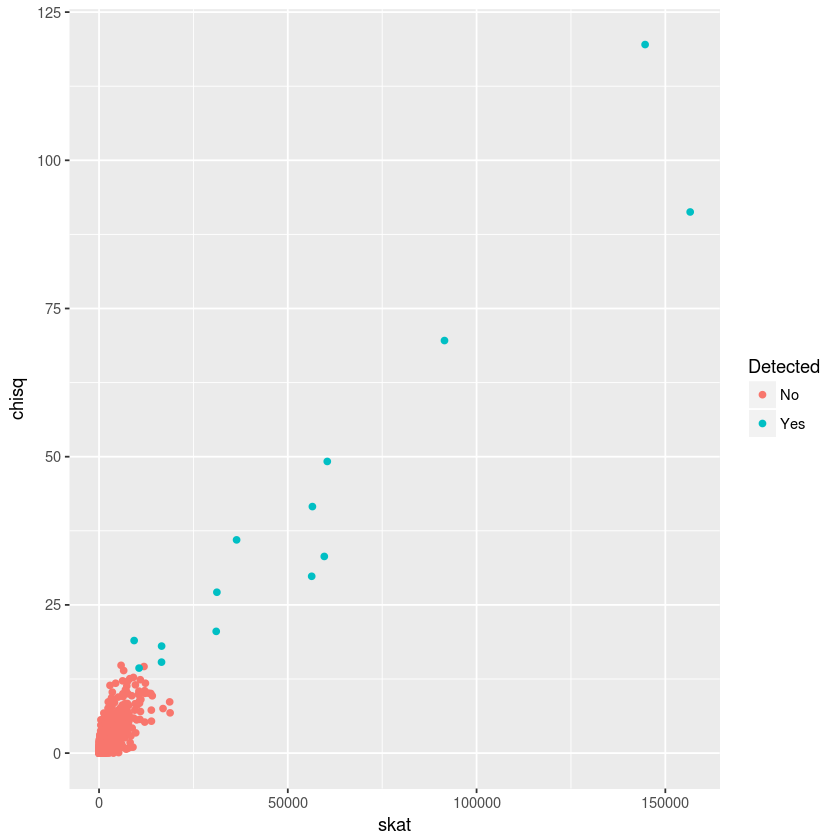

In [17]:
fit <- data.frame(skat = skat10$scores, chisq = chisq10$scores) %>%
    lm( skat ~ chisq, data = .)

lambda <- skat10$lambda/fit$coefficients[2]
eta <- skat10$eta/fit$coefficients[2]

chisq <- test_associations(CHISQ, wd, lambda, eta)
data.frame(skat = skat10$scores, chisq = chisq$scores, causal = chisq$indicator) %>%
    mutate(Detected = ifelse(causal == 1, "Yes", "No")) %>%
    ggplot(aes(x = skat, y = chisq)) +
        geom_point(aes(color = Detected))

data.frame(skat = skat10$indicator, chisq = chisq$indicator) %>%
    table

It kind of works: all true SNPs are retrieved and we have 4 extra false positives. Possibly a more precise calibration of the parameters would retrieve the same results. **We should check why those parameters where not selected.** The parameters are:

In [19]:
# good parameters
chisq$lambda
chisq$eta

# parameters found by gridsearch - consistency
chisq40$lambda
chisq40$eta

[1] 0.2180116

[1] 13.06945

[1] 8.376776e-12

[1] 41.24626

# Selection criterion

Why do results change so much depending on the depth of the gridsearch?

In [10]:
skat10$eta
skat40$eta
skat10$lambda
skat40$lambda

[1] 16681.01

[1] 36652.41

[1] 278.2559

[1] 7.443803e-08

Lambda value is particularly different. In the 40 iteration search, the connectivity is almost negligible.

In [20]:
sum(skat10$terms)
sum(skat40$terms)

[1] 935988.6

[1] 882259.2

The objective function is lesser. Why does the gridsearch fail so hard? Because it's prioritizing by consistency, and then he takes the first value that returns some consistent results. About this, we should check:

* Improve parameter optimizaition. For example make the grid search more exhaustive, scanning more in detail the regions with better values.
* Look into alternatives to consistency: 
    * In the past Chloe looked into predictivity, but there was some overfitting. Maybe it's worth checking again.
    * Maybe look at maximize the objective function while restricting the number of SNPs picked?
    * Information-based statistics, such as [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) and [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion).
* Check why those parameters are picked. scones2 discards the trivial solutions and also >1% SNPs solutions. How can it still be so consistent?

In [12]:
grid <- test_associations_custom_gridsearch(SKAT, wd, -5, 9)
acc <- lapply(grid, function(x){
    sum(skat10$indicator == x$indicator)/1000
}) %>% do.call("rbind", .)

In [13]:
summary(acc)

       V1        
 Min.   :0.0100  
 1st Qu.:0.0100  
 Median :0.0200  
 Mean   :0.4244  
 3rd Qu.:0.9900  
 Max.   :0.9920  

In [14]:
eta_magnitude <- log10(skat10$eta) %>% floor
lambda_magnitude <- log10(skat10$lambda) %>% floor

idx <- lapply(grid, function(x){
    log10(x$eta) == eta_magnitude && log10(x$lambda) == lambda_magnitude
}) %>% do.call("rbind", .) %>% which

sum(grid[[idx]]$indicator)


[1] 25

In [15]:
i = 143
eta_magnitude
log10(grid[[i]]$eta)
lambda_magnitude
log10(grid[[i]]$lambda)


[1] 4

[1] 4

[1] 2

[1] 2